## Calculate bonding curve params

In [1]:
import math
from scipy.optimize import fsolve

x_initial = 1_000_000  # Initial market cap in USD
x_final = 15_000_000  # Final market cap in USD

# Define the bonding curve equations
def equations(vars):
    a, b = vars
    eq1 = a * math.exp(b * x_initial) - initial_price
    eq2 = a * math.exp(b * x_final) - graduation_price
    return [eq1, eq2]

# Initial conditions
initial_price = 0.001  # Example initial price per token
graduation_price = 0.01  # Example graduation price per token

# Initial guess for a and b
initial_guess = [0.001, 0.0000001]

# Solve the equations to find a and b
a_opt, b_opt = fsolve(equations, initial_guess)

a_opt, b_opt


(0.0008483428982440725, 1.6447036378529e-07)

## Calculate Liquidty required

In [2]:
import scipy.integrate as integrate

# Given parameters
a = a_opt
b = b_opt


# Define the bonding curve price function
def price_function(x):
    return a * math.exp(b * x)

# Integrate the price function from x_initial to x_final
total_usdt, _ = integrate.quad(price_function, x_initial, x_final)

total_usdt


54721.10471981034

## Plot curve

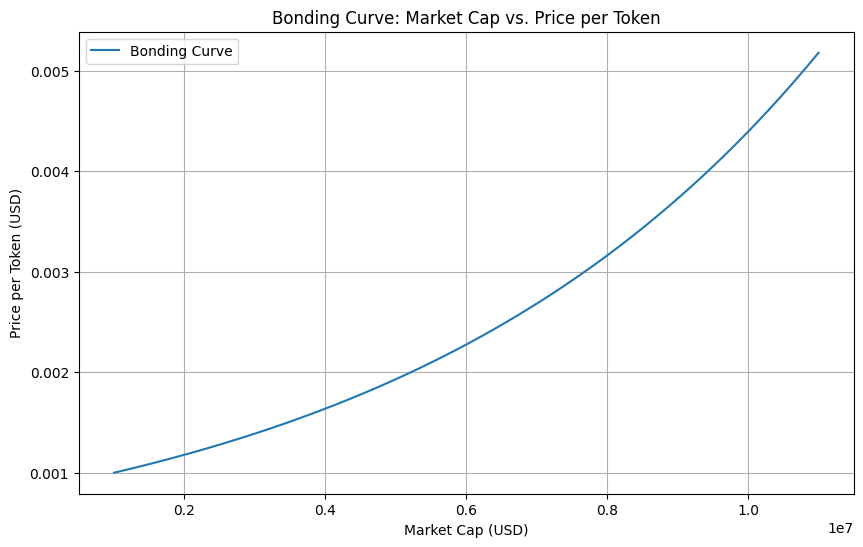

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Bonding curve function
def bonding_curve(x, a, b):
    return a * np.exp(b * x)

# Initial conditions
initial_mc = x_initial  # Initial market cap in USD
tokens_bought = np.linspace(1, 10**10, 100)  # Range of tokens bought

# Calculate the initial price
initial_price = bonding_curve(initial_mc, a_opt, b_opt)

# Calculate market cap changes and new prices
market_caps = initial_mc + tokens_bought * initial_price
new_prices = bonding_curve(market_caps, a_opt, b_opt)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(market_caps, new_prices, label='Bonding Curve')
plt.xlabel('Market Cap (USD)')
plt.ylabel('Price per Token (USD)')
plt.title('Bonding Curve: Market Cap vs. Price per Token')
plt.legend()
plt.grid(True)
plt.show()


## Calculate Tokens Purchased/Sold

In [3]:
import math

def calculate_tokens_purchased(a, b, eth_amount, initial_market_cap):
    
    # Calculate the final market cap after the trade
    final_market_cap_exp = (eth_amount * b / a) + math.exp(b * initial_market_cap)
    final_market_cap = math.log(final_market_cap_exp) / b
    
    # Calculate the number of tokens purchased
    tokens_purchased = final_market_cap - initial_market_cap
    
    return tokens_purchased,final_market_cap

def calculate_eth_received(a, b, tokens_sold, initial_market_cap):
    
    # Calculate the final market cap after the sale
    final_market_cap = initial_market_cap - tokens_sold
    
    # Calculate the USD value received from selling the tokens
    eth_received = (a / b) * (math.exp(b * initial_market_cap) - math.exp(b * final_market_cap))
    
    # Convert the USD value to ETH

    
    return eth_received,final_market_cap

# Parameters
a = 0.00000282630823
b = 0.0000000198803137  # Aggressiveness parameter
eth_amount = 1  # Amount of ETH used for the trade

initial_market_cap = 750 # Initial market cap before the trade
tokens_sold = 352574.6337614426 # Number of tokens sold

# Calculate tokens purchased
tokens_purchased,final_market_cap = calculate_tokens_purchased(a, b, eth_amount, initial_market_cap)
print(f"Tokens purchased for {eth_amount} ETH: {tokens_purchased}")

# Calculate ETH received for selling tokens
initial_market_cap=final_market_cap
eth_received,final_market_cap = calculate_eth_received(a, b, tokens_sold, initial_market_cap)
print(f"ETH received for selling {tokens_sold} tokens: {eth_received}")


Tokens purchased for 1 ETH: 352574.6337614426
ETH received for selling 352574.6337614426 tokens: 1.0000000000000084


## Stress test

In [13]:
import math

def calculate_tokens_purchased(a, b, eth_amount, eth_price, initial_market_cap):
    usd_value = eth_amount * eth_price
    final_market_cap_exp = (usd_value * b / a) + math.exp(b * initial_market_cap)
    final_market_cap = math.log(final_market_cap_exp) / b
    tokens_purchased = final_market_cap - initial_market_cap
    return tokens_purchased, final_market_cap

def calculate_eth_received(a, b, tokens_sold, eth_price, initial_market_cap):
    final_market_cap = initial_market_cap - tokens_sold
    usd_value_received = (a / b) * (math.exp(b * initial_market_cap) - math.exp(b * final_market_cap))
    eth_received = usd_value_received / eth_price
    return eth_received

def simulate_bonding_curve(a, b, eth_amount, eth_price, initial_market_caps):
    for initial_market_cap in initial_market_caps:
        tokens_purchased, final_market_cap_after_purchase = calculate_tokens_purchased(a, b, eth_amount, eth_price, initial_market_cap)
        eth_received = calculate_eth_received(a, b, tokens_purchased, eth_price, final_market_cap_after_purchase)

        print(f"Initial Market Cap: {initial_market_cap} USD")
        print(f"Tokens purchased for {eth_amount} ETH: {tokens_purchased}")
        print(f"ETH received for selling {tokens_purchased} tokens: {eth_received}")

        if eth_received > eth_amount:
            print("Exploitation detected: Trader can get more ETH than initially spent.")
        else:
            print("No exploitation: Trader cannot get more ETH than initially spent.")
        print("---------------------------------------------------")

# Parameters
a = a_opt  # Initial price parameter
b = b_opt  # Aggressiveness parameter
eth_amount = 1  # Amount of ETH used for the trade
eth_price = 4000  # Price of 1 ETH in USD
initial_market_caps = [0, 100000, 200000, 300000, 400000]  # Different initial market caps for testing

# Simulate bonding curve
simulate_bonding_curve(a, b, eth_amount, eth_price, initial_market_caps)


Initial Market Cap: 0 USD
Tokens purchased for 1 ETH: 3490455.3129608734
ETH received for selling 3490455.3129608734 tokens: 1.0
No exploitation: Trader cannot get more ETH than initially spent.
---------------------------------------------------
Initial Market Cap: 100000 USD
Tokens purchased for 1 ETH: 3446979.9504643837
ETH received for selling 3446979.9504643837 tokens: 1.0
No exploitation: Trader cannot get more ETH than initially spent.
---------------------------------------------------
Initial Market Cap: 200000 USD
Tokens purchased for 1 ETH: 3403908.317645839
ETH received for selling 3403908.317645839 tokens: 1.0
No exploitation: Trader cannot get more ETH than initially spent.
---------------------------------------------------
Initial Market Cap: 300000 USD
Tokens purchased for 1 ETH: 3361239.495474485
ETH received for selling 3361239.495474485 tokens: 1.0
No exploitation: Trader cannot get more ETH than initially spent.
---------------------------------------------------
I

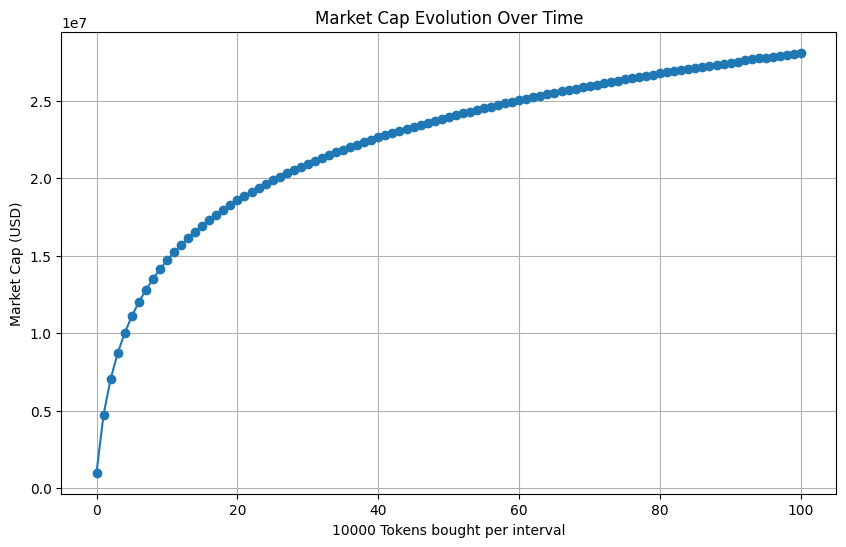

In [17]:
import math
import matplotlib.pyplot as plt

def calculate_final_market_cap(a, b, tokens_purchased, initial_market_cap):
    final_market_cap_exp = math.exp(b * tokens_purchased) + math.exp(b * initial_market_cap)
    final_market_cap = math.log(final_market_cap_exp) / b
    return final_market_cap

def simulate_market_cap_evolution(a, b, initial_market_cap, tokens_per_interval, num_intervals):
    market_caps = [initial_market_cap]
    current_market_cap = initial_market_cap

    for _ in range(num_intervals):
        current_market_cap = calculate_final_market_cap(a, b, tokens_per_interval, current_market_cap)
        market_caps.append(current_market_cap)

    return market_caps

initial_market_cap = 1000000  # Initial market cap in USD
tokens_per_interval = 10000  # Number of tokens purchased in each interval
num_intervals = 100  # Number of intervals

# Simulate market cap evolution
market_caps = simulate_market_cap_evolution(a_opt, b_opt, initial_market_cap, tokens_per_interval, num_intervals)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(market_caps, marker='o')
plt.title('Market Cap Evolution Over Time')
plt.xlabel(f'{tokens_per_interval} Tokens bought per interval')
plt.ylabel('Market Cap (USD)')
plt.grid(True)
plt.show()


### Price Evolution with MC

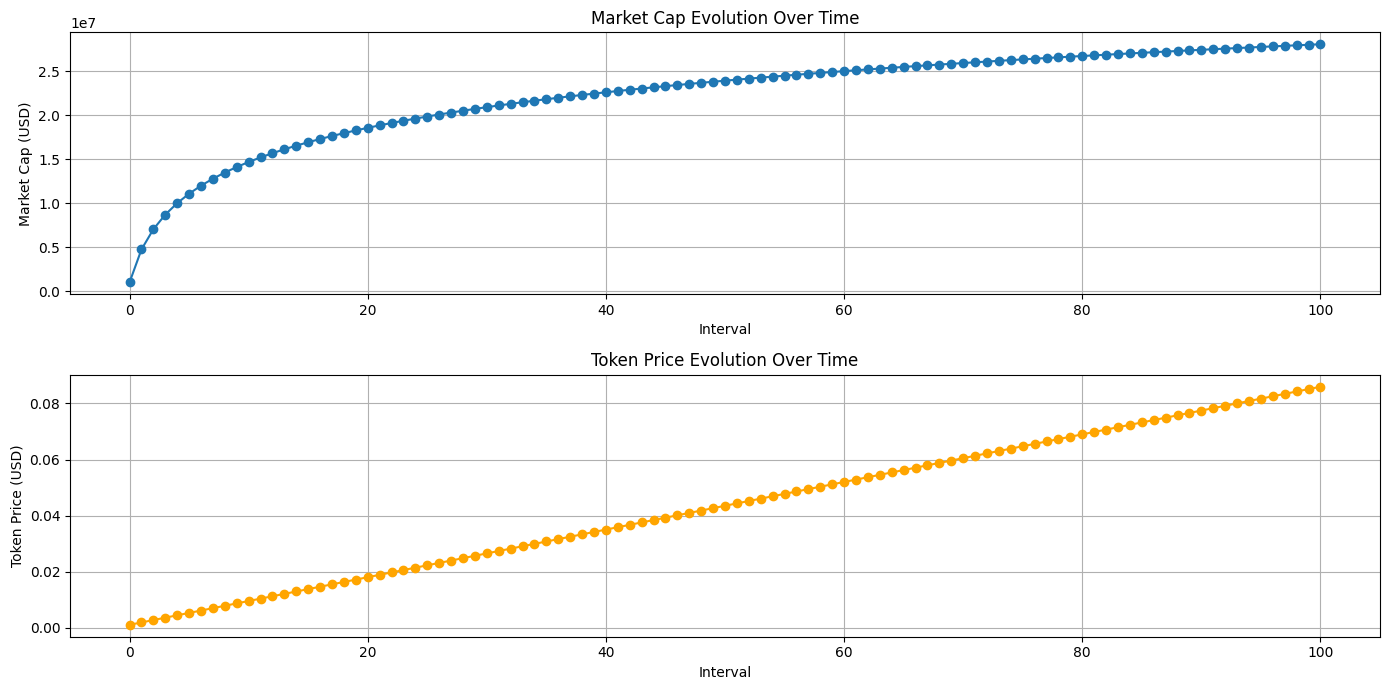

In [18]:
import math
import matplotlib.pyplot as plt

def calculate_final_market_cap(a, b, tokens_purchased, initial_market_cap):
    final_market_cap_exp = math.exp(b * tokens_purchased) + math.exp(b * initial_market_cap)
    final_market_cap = math.log(final_market_cap_exp) / b
    return final_market_cap

def calculate_token_price(a, b, market_cap):
    return a * math.exp(b * market_cap)

def simulate_market_cap_and_price_evolution(a, b, initial_market_cap, tokens_per_interval, num_intervals):
    market_caps = [initial_market_cap]
    prices = [calculate_token_price(a, b, initial_market_cap)]
    current_market_cap = initial_market_cap

    for _ in range(num_intervals):
        current_market_cap = calculate_final_market_cap(a, b, tokens_per_interval, current_market_cap)
        market_caps.append(current_market_cap)
        prices.append(calculate_token_price(a, b, current_market_cap))

    return market_caps, prices

# Parameters# Simulate market cap and price evolution
market_caps, prices = simulate_market_cap_and_price_evolution(a, b, initial_market_cap, tokens_per_interval, num_intervals)

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(market_caps, marker='o')
plt.title('Market Cap Evolution Over Time')
plt.xlabel('Interval')
plt.ylabel('Market Cap (USD)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(prices, marker='o', color='orange')
plt.title('Token Price Evolution Over Time')
plt.xlabel('Interval')
plt.ylabel('Token Price (USD)')
plt.grid(True)

plt.tight_layout()
plt.show()
